In [1]:
sparkSql = (SparkSession.builder
         .master("local")
         .appName("Kiva Exploration")
         .getOrCreate())

loans = sparkSql.read.format('json').load('kiva-data/loans.json')
loans.registerTempTable('loans')
lenders = sparkSql.read.format('json').load('kiva-data/lenders.json')
lenders.registerTempTable('lenders')
loans_lenders = sparkSql.read.format('json').load('kiva-data/loans_lenders.json')
loans_lenders.registerTempTable('loans_lenders')

# Custom Functions

## Gender Ratio

0 = All female

1 = All male

In [2]:
import pyspark

def gender_ratio(array):
    num_males = 0
    for item in array:
        if item.gender == 'M':
            num_males += 1
            
    return float(num_males) / len(array)

sparkSql.udf.register('gender_ratio',
                      gender_ratio,
                      pyspark.sql.types.FloatType())

## Fetch GDP

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np


# Load country info data
country_codes_raw = pd.read_csv('economic-data/country-codes.csv')
country_gdp_raw = pd.read_csv('economic-data/country-gdp.csv')

# Clean country codes data
country_codes = country_codes_raw[['official_name_en', 'ISO3166-1-Alpha-2', 
                                   'ISO3166-1-Alpha-3', 'ISO4217-currency_alphabetic_code']]

# Clean gdp data
country_gdp = country_gdp_raw.drop(country_gdp_raw.columns[[0, 1]], axis=1)
country_gdp.columns = ['name', 'country_code_3', '2002', '2003', '2004', '2005', '2006',
                       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']

# Merge gdp and code
country_gdp = pd.merge(country_gdp, country_codes, left_on='country_code_3', right_on='ISO3166-1-Alpha-3', how='left')
country_gdp.drop(['official_name_en', 'ISO3166-1-Alpha-3', 'country_code_3'], axis=1, inplace=True)
country_gdp = country_gdp.rename(columns = {'ISO3166-1-Alpha-2':'country_code',
                                            'ISO4217-currency_alphabetic_code':'currency_code'})
country_gdp.replace('..', np.nan, inplace=True)

# Reorder columns
cols = list(country_gdp.columns)
cols.insert(1, cols.pop(cols.index('country_code')))
cols.insert(2, cols.pop(cols.index('currency_code')))
country_gdp = country_gdp.reindex(columns= cols)

def gdp(country_code, disbursal_date):
    def historical_gdp(array):
        array = np.array(map(float, array))
        array = array[~np.isnan(array)] # Remove NaN
        if len(array) == 0: # No GDP values
            return 0
        return float(np.mean(array, dtype=np.float64))
        
    # TODO: Unable to resolve country code WorldBank dataset has wrong alpha 3 codes e.g. Andorra causing issues
    try:
        float(country_code)
        return 0
    except:
        if country_code not in list(country_gdp['country_code']):
            return 0 # TODO: Bad solution ?   
    
    # Get the historical average GDP if no disbursal date
    all_gdp = country_gdp[country_gdp.country_code == country_code].values[0][3:]
    if (disbursal_date is None): # or (country_gdp[date][country_gdp.country_code == country_code] == float('Nan')):
        return historical_gdp(all_gdp)
    
    date = str(datetime.strptime(disbursal_date, '%Y-%m-%dT%H:%M:%SZ').year)
    # Get the historical average GDP if no GDP for that year
    if pd.isnull(country_gdp[date][country_gdp.country_code == country_code].values[0]):
        return historical_gdp(all_gdp)
    
    return float(country_gdp[date][country_gdp.country_code == country_code].values[0])

sparkSql.udf.register('gdp', gdp, pyspark.sql.types.FloatType())

## Fetch Exchange Rates

In [4]:
currencies_raw = pd.read_csv('economic-data/currencies.csv')
# Cleanup
currencies = currencies_raw.drop(country_gdp_raw.columns[[0, 1]], axis=1)
currencies.columns = ['country_name', 'country_code_3', '2002', '2003', '2004', '2005', '2006',
                       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']

# Get ISO 2 code
currencies = pd.merge(currencies, country_codes, left_on='country_code_3', right_on='ISO3166-1-Alpha-3', how='left')
currencies.drop(['official_name_en', 'ISO3166-1-Alpha-3', 'country_code_3'], axis=1, inplace=True)
currencies = currencies.rename(columns = {'ISO3166-1-Alpha-2':'country_code',
                                            'ISO4217-currency_alphabetic_code':'currency_code'})
currencies.replace('..', np.nan, inplace=True)

# Add code for European Union
currencies.set_value(217, 'country_code', 'EU')
currencies.set_value(217, 'currency_code', 'EMU')

# Reorder columns
cols = list(currencies.columns)
cols.insert(1, cols.pop(cols.index('country_code')))
cols.insert(2, cols.pop(cols.index('currency_code')))
currencies = currencies.reindex(columns=cols)

def xchange_rate(country_code, disbursal_date):
    def historical_rates(array):
        array = np.array(map(float, array))
        array = array[~np.isnan(array)] # Remove NaN
        if len(array) == 0: # No rate values
            return 1
        return float(np.mean(array, dtype=np.float64))
    
    eu = ['AT','BE','BG','HR','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE',
          'IT','LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE','GB']
    us = ['AS','GU','MP','PR','UM','VI']
    try:
        float(country_code) # Country code unknown?
        if pd.isnull(country_code):
            return 1 # TODO: Bad solution ??
    except:
        if country_code in eu:
            country_code = 'EU'
        elif country_code in us:
            country_code = 'US'
        if country_code not in list(currencies['country_code']):
            return 1
        
        
    # TODO: Unable to resolve country code WorldBank dataset has wrong alpha 3 codes e.g. Andorra causing
    try:
        float(country_code)
        return 0
    except:
        if country_code not in list(currencies['country_code']):
            return 0 # TODO: Bad solution    
    
    # Get the historical average exchange rate if no disbursal date
    all_rates = currencies[currencies.country_code == country_code].values[0][3:]
    if (disbursal_date is None): # or (country_gdp[date][country_gdp.country_code == country_code] == float('Nan')):
        return historical_rates(all_rates)
    
    date = str(datetime.strptime(disbursal_date, '%Y-%m-%dT%H:%M:%SZ').year)
    # Get the historical average exchange rate if no GDP for that year
    if pd.isnull(currencies[date][currencies.country_code == country_code].values[0]):
        return historical_rates(all_rates)
    
    return float(currencies[date][currencies.country_code == country_code].values[0])

sparkSql.udf.register('xchange_rate', xchange_rate, pyspark.sql.types.FloatType())

# Fetch actual data

Get all data that we are going to use, get dummies, then split into train/validation/test.

Query our datasets to train on.

In [6]:
query = '''
SELECT
    id,
    activity,
    size(borrowers) as num_borrowers,
    gender_ratio(borrowers) as gender_ratio,
    lender_count,
    location.country,
    location.country_code,
    partner_id,
    sector,
    tags,
    DATEDIFF(terms.disbursal_date, planned_expiration_date) as loan_length,
    terms.disbursal_amount,
    terms.disbursal_currency,
    terms.disbursal_date,
    size(terms.scheduled_payments) as num_repayments,
    terms.repayment_interval,
    CASE WHEN
        (status = 'refunded') OR
        (status = 'defaulted') OR
        (status = 'deleted') OR
        (status = 'issue') OR
        (status = 'inactive_expired') OR
        (status = 'expired') OR
        (status = 'inactive') OR
        (delinquent = True) THEN 1 ELSE 0 END AS bad_loan,
    gdp(location.country_code, terms.disbursal_date) as gdp,
    xchange_rate(location.country_code, terms.disbursal_date) as xchange_rate,
    status,
    delinquent
    
FROM loans
WHERE
    status != 'fundraising' AND
    status != 'funded'
'''

dataset = sparkSql.sql(query).toPandas()

# Data Splits

In [8]:
X_columns = [
    'activity', 'num_borrowers', 'gender_ratio',
    'lender_count', 'country', 'partner_id', 'sector',
    'loan_length', 'disbursal_amount', 'disbursal_currency',
    'num_repayments', 'repayment_interval', 'gdp', 'xchange_rate'
]

y_column = ['bad_loan']

dummy_set = pd.get_dummies(dataset[X_columns + y_column])
dummy_set.to_csv('processed_dummy.csv')

Now we can restart the kernel to clear memory, and start processing.

In [1]:
import pandas as pd

processed_dummy = pd.read_csv('processed_dummy.csv', index_col=0)

In [3]:
import numpy as np

train, validate, test = np.split(processed_dummy.sample(frac=1, random_state=0),
                                 [int(.6*len(processed_dummy)),
                                  int(.8*len(processed_dummy))])

train.to_csv('processed_train.csv')
validate.to_csv('processed_validate.csv')
test.to_csv('processed_test.csv')

# Testing all the models

In [1]:
import pandas as pd
train = pd.read_csv('processed_train.csv', index_col=0).dropna(axis=1)

Naive guess:

In [2]:
train_x = train.drop('bad_loan', axis=1)
train_y = train['bad_loan']

1 - train_y.mean()

0.89836166750827584

In [3]:
from itertools import product
import pickle
from sklearn.linear_model import LogisticRegression

for C in [1, .1, .01, .001, .0001]:
    lr = LogisticRegression(C=C, solver='sag', max_iter=100)

    lr.fit(train_x, train_y)
    with open('lr_{}.pickle'.format(C), 'w') as handle:
        pickle.dump(lr, handle)
        
    del(lr)
    print("Finished training {}".format(C))

/usr/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Finished training 1
Finished training 0.1
Finished training 0.01
Finished training 0.001
Finished training 0.0001


In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

# Number of columns is 342
for n_components in [342, 150, 20, 5, 1]:
    lda = LinearDiscriminantAnalysis(n_components=n_components,
                                     solver='lsqr')
    lda.fit(train_x, train_y)
    with open('lda_{}.pickle'.format(n_components), 'w') as handle:
        pickle.dump(lda, handle)
    
    del(lda)
    print("Finished training {}".format(n_components))

Finished training 342
Finished training 150
Finished training 20
Finished training 5
Finished training 1


In [5]:
from sklearn.ensemble import RandomForestClassifier

for n_estimators in [10, 5, 3, 1]:
    rf = RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(train_x, train_y)
    with open('rf_{}.pickle'.format(n_estimators), 'w') as handle:
        pickle.dump(rf, handle)
        
    del(rf)        
    print("Finished training {}".format(n_estimators))

Finished training 10
Finished training 5
Finished training 3
Finished training 1


# Evaluating the Results

In [1]:
import pandas as pd
valid = pd.read_csv('processed_validate.csv', index_col=0).dropna(axis=1)

valid_x = valid.drop('bad_loan', axis=1)
valid_y = valid['bad_loan']

In [2]:
import pickle
lr_params = [1, .1, .01, .001, .0001]

for C in lr_params:
    with open('lr_{}.pickle'.format(C)) as handle:
        model = pickle.load(handle)
        
        score = model.score(valid_x, valid_y)
        
        print('Logistic Regression, C={}; Score: {}'.format(
                C, score
            ))

Logistic Regression, C=1; Score: 0.89904155569
Logistic Regression, C=0.1; Score: 0.89904155569
Logistic Regression, C=0.01; Score: 0.89904155569
Logistic Regression, C=0.001; Score: 0.89904155569
Logistic Regression, C=0.0001; Score: 0.89904155569


In [3]:
lda_components = [342, 150, 20, 5, 1]

for n_components in lda_components:
    with open('lda_{}.pickle'.format(n_components)) as handle:
        model = pickle.load(handle)
        
        score = model.score(valid_x, valid_y)
        
        print('Linear Discriminant Analysis, components={}; Score: {}'.format(
                n_components, score
            ))

Linear Discriminant Analysis, components=342; Score: 0.896526629504
Linear Discriminant Analysis, components=150; Score: 0.896526629504
Linear Discriminant Analysis, components=20; Score: 0.896526629504
Linear Discriminant Analysis, components=5; Score: 0.896526629504
Linear Discriminant Analysis, components=1; Score: 0.896526629504


In [4]:
rf_estimators = [10, 5, 3, 1]

for estimators in rf_estimators:
    with open('rf_{}.pickle'.format(estimators)) as handle:
        model = pickle.load(handle)
        
        score = model.score(valid_x, valid_y)
        
        print('Random Forests, estimators: {}; Score: {}'.format(
                estimators, score
            ))

Random Forests, estimators: 10; Score: 0.934577264671
Random Forests, estimators: 5; Score: 0.93108211135
Random Forests, estimators: 3; Score: 0.926601780251
Random Forests, estimators: 1; Score: 0.915037080309


# Column Significance

In [1]:
import pandas as pd

train = pd.read_csv('processed_train.csv', index_col=0).dropna(axis=1)
valid = pd.read_csv('processed_validate.csv', index_col=0).dropna(axis=1)

In [7]:
activity_columns = ('Activity', list(filter(
            lambda x: 'activity' in x,
            train.columns)))
dcurrency_columns = ('Disbursal Currency', list(filter(
            lambda x: 'disbursal_currency' in x,
            train.columns)))
country_columns = ('Country', list(filter(
                lambda x: 'country' in x,
                train.columns)))
sector_columns = ('Sector', list(filter(
                lambda x: 'sector' in x,
                train.columns)))
repayment_columns = ('Repayment', list(filter(
                lambda x: 'repayment' in x,
                train.columns)))
nborrowers_columns = ('Number of Borrowers', ['num_borrowers'])
gratio_columns = ('Gender Ratio', ['gender_ratio'])
nlenders_columns = ('Lender Count', ['lender_count'])
damount_columns = ('Disbursal Amount', ['disbursal_amount'])

colgroups = [
    activity_columns, dcurrency_columns, country_columns,
    sector_columns, repayment_columns, nborrowers_columns,
    gratio_columns, nlenders_columns, damount_columns
]

In [9]:
from sklearn.ensemble import RandomForestClassifier

def validate_column_group(train, valid, colgroup):
    sub_group = train.drop(colgroup, axis=1)
    train_x = sub_group.drop('bad_loan', axis=1)
    train_y = sub_group['bad_loan']
    
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(train_x, train_y)
    
    valid_subgroup = valid.drop(colgroup, axis=1)
    valid_x = valid_subgroup.drop('bad_loan', axis=1)
    valid_y = valid_subgroup['bad_loan']
    score = rf.score(valid_x, valid_y)
    
    return score
    
for name, colgroup in colgroups:
    score = validate_column_group(train, valid, colgroup)
    
    print 'Removing columns: {}'.format(name)
    print 'Score: {:.3f}'.format(score*100)
    print

Removing columns: Activity
Score: 93.569

Removing columns: Disbursal Currency
Score: 93.458

Removing columns: Country
Score: 93.381

Removing columns: Sector
Score: 93.628

Removing columns: Repayment
Score: 93.180

Removing columns: Number of Borrowers
Score: 93.450

Removing columns: Gender Ratio
Score: 93.422

Removing columns: Lender Count
Score: 90.606

Removing columns: Disbursal Amount
Score: 92.342



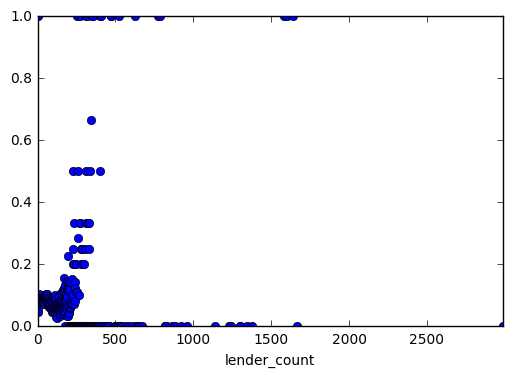

In [16]:
%matplotlib inline
train.groupby('lender_count')['bad_loan'].mean().plot(style='o');

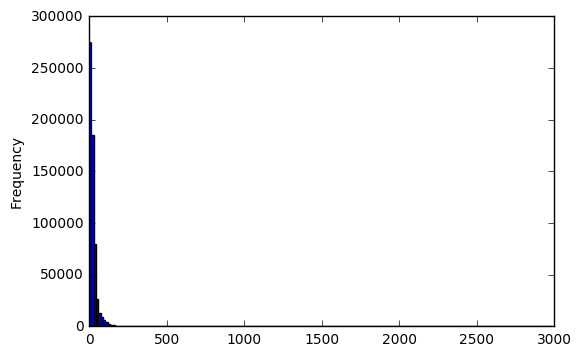

In [19]:
train['lender_count'].plot(kind='hist', bins=200);

Finally, want to get an idea of how well this model will perform in production:

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pickle

train = pd.read_csv('processed_train.csv', index_col=0).dropna(axis=1)
valid = pd.read_csv('processed_validate.csv', index_col=0).dropna(axis=1)

full = pd.concat((train, valid))
full_x = full.drop('bad_loan', axis=1)
full_y = full['bad_loan']
rf = RandomForestClassifier(n_estimators=10)

rf.fit(full_x, full_y)

with open('rf_validated.pickle', 'w') as handle:
        pickle.dump(rf, handle)

In [1]:
import pandas as pd
import pickle

test = pd.read_csv('processed_test.csv', index_col=0).dropna(axis=1)
test_x = test.drop('bad_loan', axis=1)
test_y = test['bad_loan']
with open('rf_validated.pickle') as handle:
    rf = pickle.load(handle)
    score = rf.score(test_x, test_y)
    
    print 'Model test accuracy: {:.3f}%'.format(score*100)
    
print 'Naive test accuracy: {:.3f}%'.format(
    (1 - test_y.mean())*100
)

Model test accuracy: 93.651%
Naive test accuracy: 89.952%
